In [39]:
import pandas as pd
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [40]:
data_dir = ".\\DATA\\HAM10000_images_part_1_and_2"  # directory with all images

In [41]:
dest_dir = ".\\DATA\\recognized\\"  # directory where all images will be divided into subdirectories 

In [42]:
df = pd.read_csv(".\\DATA\\HAM10000_metadata")  # read metadata

In [43]:
df = df.rename(columns={"dx": "diagnosis"})
df = df[["image_id", "diagnosis"]]

In [44]:
for label in df['diagnosis'].unique():
    os.makedirs(os.path.join(dest_dir, label), exist_ok=True)  # make directory for each label

In [45]:
for index, row in df.iterrows():
    source_file = os.path.join(data_dir, f"{row['image_id']}.jpg")
    destination_file = os.path.join(dest_dir, row['diagnosis'], f"{row['image_id']}.jpg")
    shutil.copyfile(source_file, destination_file)  # copy image to defined earlier subdirectory 

In [46]:
datagen = ImageDataGenerator()  # initialize ImageDataGenerator

In [47]:
images_data_keras = datagen.flow_from_directory(
    directory=dest_dir,
    class_mode='categorical',
    batch_size=16,  
    target_size=(200, 150),
)  # load all images in 'rgb' format using batch approach

Found 10015 images belonging to 7 classes.


In [48]:
X = []
y = []
for i in range(len(images_data_keras)):
    images, labels = images_data_keras[i]
    X.extend(images)
    y.extend(labels)  # add images to X and labels to y

In [49]:
X = np.array(X)

In [50]:
X = [image.flatten() for image in X]  # change np.array's dimension into one

In [51]:
X = np.array(X)  # ensure that X is stored as np.array

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # divide data into train and test 

In [53]:
scaler = StandardScaler()  # create StandardScaler instance

In [54]:
X_train_scaled = scaler.fit_transform(X_train)

In [55]:
X_test_scaled = scaler.transform(X_test)

In [56]:
pca = PCA()  # create PCA instance

In [57]:
pca.fit(X_train)  # fit to X_train in order to choose number of components

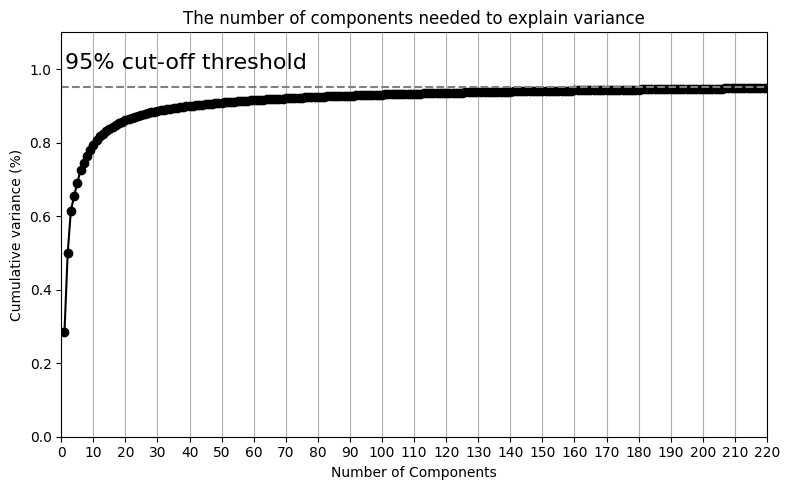

In [62]:

plt.rcParams["figure.figsize"] = (8,5)

fig, ax = plt.subplots()
xi = np.arange(1, 8013, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='-', color='black')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 8013, step=10)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='grey', linestyle='--')
plt.text(1.1, 1, '95% cut-off threshold', color = 'black', fontsize=16)
plt.xlim(0,220)
ax.grid(axis='x')
plt.tight_layout();  # n_components = 150 explain 95% of variance

In [63]:
pca = PCA(n_components=150)  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_scaled)  
X_test_pca = pca.transform(X_test_scaled)  